In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from catboost import CatBoostClassifier
from sklearn.preprocessing import Imputer

In [3]:
import warnings
warnings.filterwarnings('ignore')
# ---

%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 100
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np

## chargement de la data

In [4]:
customers = pd.read_csv("customers.csv")
products = pd.read_csv("products.csv")
X_train = pd.read_csv("X_train.csv")
X_test   = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv")

In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067290 entries, 0 to 1067289
Data columns (total 20 columns):
OrderNumber          1067290 non-null int64
VariantId            1067290 non-null int64
LineItem             1067290 non-null int64
CustomerId           1067290 non-null int64
OrderStatusLabel     1067290 non-null object
OrderTypelabel       1067290 non-null object
SeasonLabel          1067290 non-null object
PayementModeLabel    1067290 non-null object
CustomerTypeLabel    1067290 non-null object
IsoCode              1067290 non-null object
DeviceTypeLabel      1067290 non-null object
PricingTypeLabel     1067290 non-null object
TotalLineItems       1067290 non-null int64
Quantity             1067290 non-null int64
UnitPMPEUR           1067290 non-null object
OrderCreationDate    1067290 non-null object
OrderShipDate        1067290 non-null object
OrderNumCustomer     1067290 non-null int64
IsOnSale             1059475 non-null float64
BillingPostalCode    1067238 non-null 

In [6]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780238 entries, 0 to 780237
Data columns (total 5 columns):
CustomerId        780238 non-null float64
CountryISOCode    780238 non-null object
BirthDate         780238 non-null object
Gender            780238 non-null object
FirstOrderDate    780238 non-null object
dtypes: float64(1), object(4)
memory usage: 29.8+ MB


In [7]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533520 entries, 0 to 533519
Data columns (total 25 columns):
VariantId                533520 non-null float64
GenderLabel              533520 non-null object
MarketTargetLabel        533520 non-null object
SeasonLabel              533520 non-null object
SeasonalityLabel         533520 non-null object
BrandId                  533520 non-null float64
UniverseLabel            533520 non-null object
TypeBrand                533520 non-null object
ProductId                533520 non-null float64
ProductType              532418 non-null object
SupplierColor            533520 non-null object
ProductColorId           533520 non-null float64
MinSize                  533520 non-null float64
MaxSize                  533520 non-null float64
CalfTurn                 63981 non-null float64
UpperHeight              120019 non-null float64
HeelHeight               511895 non-null float64
PurchasePriceHT          533520 non-null float64
IsNewCollection 

In [8]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067290 entries, 0 to 1067289
Data columns (total 4 columns):
OrderNumber          1067290 non-null int64
LineItem             1067290 non-null int64
ReturnQuantity       1067290 non-null float64
ReturnQuantityBin    1067290 non-null float64
dtypes: float64(2), int64(2)
memory usage: 32.6 MB


## jointure des tables 

In [9]:
merge_train=pd.merge(X_train,customers,how='left',on='CustomerId')
merge_test=pd.merge(X_test,customers,how='left',on='CustomerId')

In [10]:
merge_all_train=pd.merge(merge_train,products,how='left',on='VariantId')
merge_all_test=pd.merge(merge_test,products,how='left',on='VariantId')

In [14]:
pd.options.display.max_columns=400
merge_all_train.describe()

,OrderNumber,LineItem,TotalLineItems,Quantity,OrderNumCustomer,IsOnSale,BrandId,ProductId,ProductColorId,MinSize,MaxSize,CalfTurn,UpperHeight,HeelHeight,PurchasePriceHT,IsNewCollection
count,1.067290e+06,1.067290e+06,1.067290e+06,1.067290e+06,1.067290e+06,1.059475e+06,689670.000000,689670.000000,689670.000000,689670.000000,689670.000000,154611.000000,205118.000000,646538.000000,689670.000000,689670.000000
mean,4.998603e+07,1.449695e+00,1.912211e+00,1.003925e+00,3.873052e+00,3.006102e-01,461.823450,51135.072835,99624.035009,42.903510,42.969659,6.070500,7.276438,2.367253,33.340630,0.006764
std,2.892062e+07,1.074525e+00,1.859919e+00,1.049004e-01,1.235264e+01,4.585236e-01,362.150843,15799.393135,20459.483612,30.639519,30.657170,13.690816,10.479232,3.376070,19.965191,0.081966
min,5.100000e+01,1.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00,3.000000,36.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.010000,0.000000
25%,2.475954e+07,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,122.000000,44781.000000,84409.000000,37.000000,37.000000,0.000000,0.000000,0.000000,20.000000,0.000000
50%,4.992306e+07,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,295.000000,52800.000000,95120.000000,39.000000,39.000000,0.000000,0.000000,0.000000,30.000000,0.000000
75%,7.517581e+07,2.000000e+00,2.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00,769.000000,62612.000000,116187.000000,41.000000,41.000000,0.000000,10.000000,3.000000,42.100000,0.000000
max,9.999179e+07,3.900000e+01,2.000000e+02,3.000000e+01,4.430000e+02,1.000000e+00,1276.000000,91150.000000,168850.000000,720.000000,720.000000,52.000000,58.000000,18.000000,1100.000000,1.000000


## Type de données:

### catégorique :

**classe binaire:**

In [11]:
def iscategorical_bin(col):
    unique=pd.unique(col)
    taille=unique.shape[0]
    if (taille==2):
        return True
    else:
        return False
t=0
col=merge_all_train.columns 
col_cat_bin=[]
col_cat_bin=np.array(col_cat_bin)
for i in col:
    if (iscategorical_bin(merge_all_train[i])):
        print(t,i)
        col_cat_bin=np.append(col_cat_bin,i)
        t=t+1

0 OrderTypelabel
1 SeasonLabel_x
2 CustomerTypeLabel


**Multiclasse:**

In [12]:
def iscategorical_mult(col):
    unique=pd.unique(col)
    taille=unique.shape[0]
    if (taille<200 and taille>2):
        return True
    else:
        return False
t=0
col=merge_all_train.columns 
col_cat_mult=[]
col_cat_mult=np.array(col_cat_mult)
for i in col:
    if (iscategorical_mult(merge_all_train[i])):
        print(t,i)
        col_cat_mult=np.append(col_cat_mult,i)
        t=t+1

0 LineItem
1 PayementModeLabel
2 IsoCode
3 DeviceTypeLabel
4 PricingTypeLabel
5 TotalLineItems
6 Quantity
7 IsOnSale
8 CountryISOCode
9 Gender
10 GenderLabel
11 MarketTargetLabel
12 SeasonLabel_y
13 SeasonalityLabel
14 UniverseLabel
15 TypeBrand
16 ProductType
17 MinSize
18 MaxSize
19 CalfTurn
20 UpperHeight
21 HeelHeight
22 IsNewCollection
23 SubtypeLabel
24 UpperMaterialLabel
25 LiningMaterialLabel
26 OutSoleMaterialLabel
27 RemovableSole
28 SizeAdviceDescription


In [13]:
a=merge_all_train.columns
rest_bin=np.setdiff1d(a,col_cat_bin)
rest_all=np.setdiff1d(rest_bin,col_cat_mult)

### numérique :

In [37]:
remaining_col=merge_all_train[['BillingPostalCode', 'BirthDate', 'BrandId', 'CustomerId',
       'FirstOrderDate', 'OrderCreationDate', 'OrderNumCustomer',
       'OrderNumber', 'OrderShipDate', 'OrderStatusLabel',
       'ProductColorId', 'ProductId', 'PurchasePriceHT', 'SupplierColor',
       'UnitPMPEUR', 'VariantId']]

In [38]:
remaining_col.dtypes

BillingPostalCode     object
BirthDate             object
BrandId              float64
CustomerId            object
FirstOrderDate        object
OrderCreationDate     object
OrderNumCustomer       int64
OrderNumber            int64
OrderShipDate         object
OrderStatusLabel      object
ProductColorId       float64
ProductId            float64
PurchasePriceHT      float64
SupplierColor         object
UnitPMPEUR           float64
VariantId             object
dtype: object

### Variable de type texte :

In [39]:
merge_all_train[['BillingPostalCode','SupplierColor']].head()

,BillingPostalCode,SupplierColor
0,87000,NaN
1,87000,NaN
2,77700,Negro
3,44600,NaN
4,44600,Vitello Nero


### Variable temporelle :

In [40]:
merge_all_train[['BirthDate','OrderCreationDate','OrderShipDate','FirstOrderDate']].head()

,BirthDate,OrderCreationDate,OrderShipDate,FirstOrderDate
0,1958-03-05 00:00:00,2011-10-26 12:10:48,2011-10-26 18:27:00,2011-10-26 12:10:48
1,1958-03-05 00:00:00,2011-10-26 12:10:48,2011-10-26 18:27:00,2011-10-26 12:10:48
2,1972-06-14 00:00:00,2011-10-26 12:11:38,2011-10-26 17:48:00,2011-10-26 12:11:38
3,1970-05-14 00:00:00,2011-10-26 12:13:09,2011-10-26 17:59:00,2011-10-26 12:13:09
4,1970-05-14 00:00:00,2011-10-26 12:13:09,2011-10-26 17:59:00,2011-10-26 12:13:09


### Selection des différentes variables explicatives:

### Elimination des Identifiants:

Dans notre modèle, nous avons décidé de ne pas prendre en considération les différents identifiants car ils prennent des valeurs distinctes et donc n'ont pas d'impact positif sur le modèle.

### Correlation 

In [28]:
col=np.setdiff1d(merge_all_train.columns,['SizeAdviceDescription','SubtypeLabel','RemovableSole','HeelHeight','UpperHeight','LiningMaterialLabel', 'OutSoleMaterialLabel', 'UpperMaterialLabel' ,'CalfTurn'])

In [29]:
correlation=pd.merge(merge_all_train[col],y_train)
correl=correlation.corr()

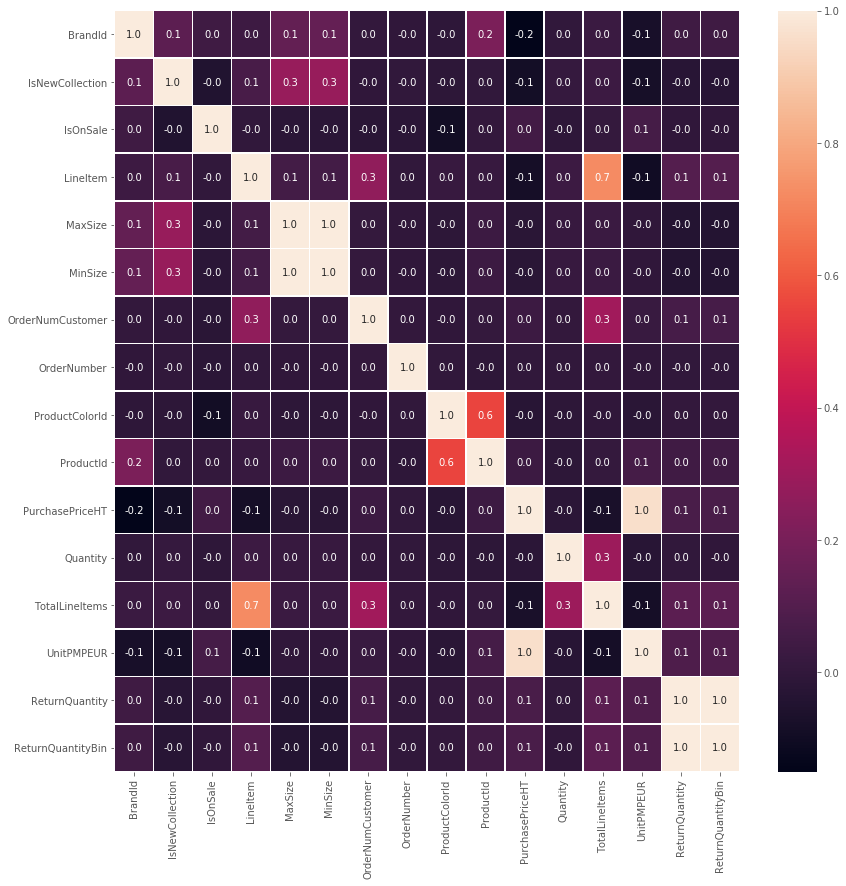

In [30]:
import seaborn as sns # data visualization library  
f,ax = plt.subplots(figsize=(14, 14))
sns.heatmap(correl, annot=True, linewidths=.5, fmt= '.1f',ax=ax)

**Interpretation**: Nous remarquons à partir de cette figure de correlation entre les différentes variables explicatives que MaxSize et MinSize sont fortement corrélées et il suffit donc de garder qu'une seule variable. Nous avons choisi de garder MaxSize.

In [86]:
col_remain=np.setdiff1d(col,['MinSize','HeelHeight','UpperHeight','UpperMaterialLabel','CalfTurn','CountryISOCode','OutSoleMaterialLabel'])

### Visualisation des variables:

In [10]:
col=col_remain 
col_cat_bin_remain=[]
col_cat_bin_remain=np.array(col_cat_bin_remain)
for i in col:
    if (iscategorical_bin(merge_all_train[i])):
        col_cat_bin_remain=np.append(col_cat_bin_remain,i)

NameError: name 'col_remain' is not defined

### Visualisation des variables categorique:

In [ ]:
def fonction_visualisation_en_bar(merge_all_train,columnName,sizefig=(15,8)):
    f = plt.figure()
    df=merge_all_train[y==1][columnName]
    df=df.reset_index()
    df1=merge_all_train[y==0][columnName]
    df1=df1.reset_index()
    a=df.groupby(columnName).count()
    b=df1.groupby(columnName).count()
    t=a.reset_index()
    t.rename(columns={'index':'count_returned'}, inplace=True)
    t1=b.reset_index()
    t1.rename(columns={'index':'count_not_returned'}, inplace=True)
    u=pd.merge(t,t1)
    res1=u.set_index(columnName).plot.bar(stacked=True,figsize=sizefig,title='Le nombre totale de retour par catégorie')
    u['Proportion_retour']=u['count_returned']/(u['count_not_returned']+u['count_returned'])
    u1=u[[columnName,'Proportion_retour']]
    res2=u1.set_index(columnName).plot.bar()
    fig_Proportion_retour = res2.get_figure()
    fig_Proportion_retour.savefig(columnName+'_Proportion_retour.jpg')
    fig_total = res1.get_figure()
    fig_total.savefig(columnName+'_total.jpg')
#     u['retour/gardé']=u['count_returned']/(u['count_not_returned'])
#     u2=u[[columnName,'retour/gardé']]
#     res3=u2.set_index(columnName).plot.bar(title='retour/gardé')
    return res1,res2

In [99]:
y=y_train.ReturnQuantityBin

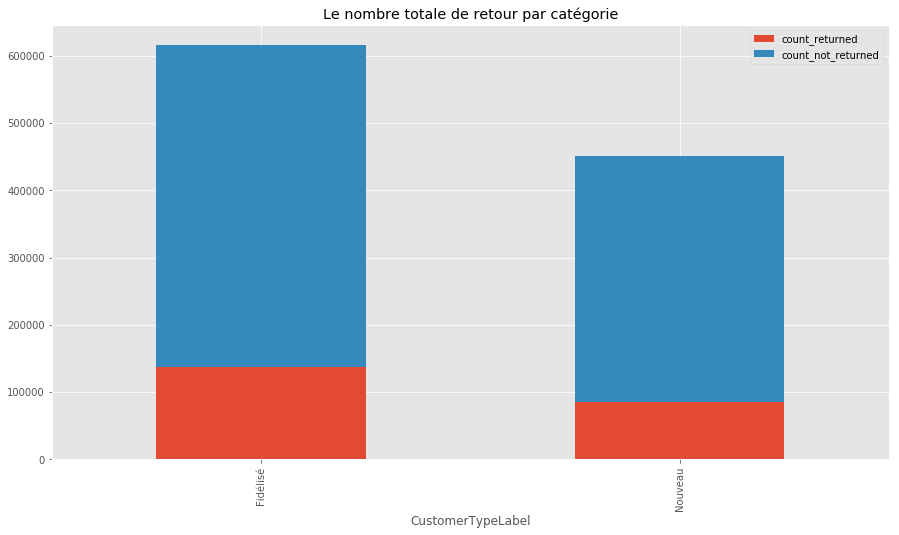

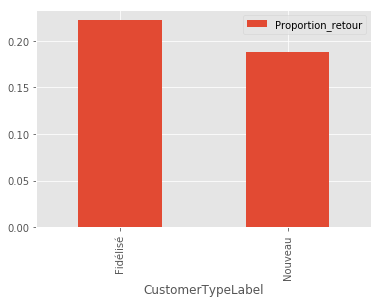

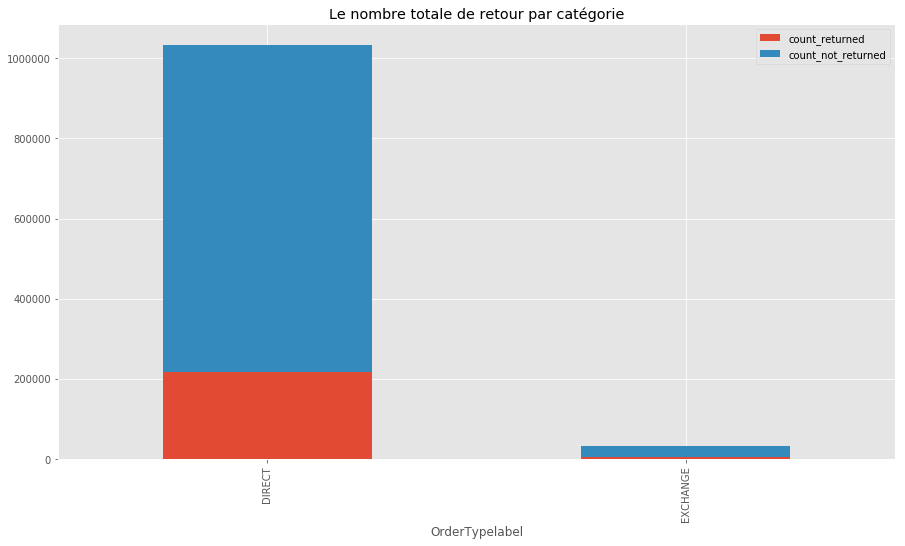

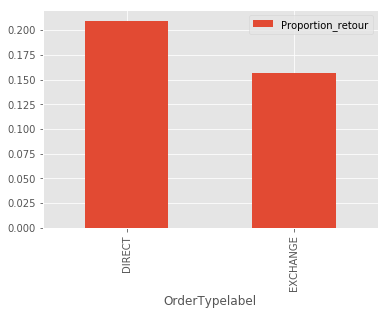

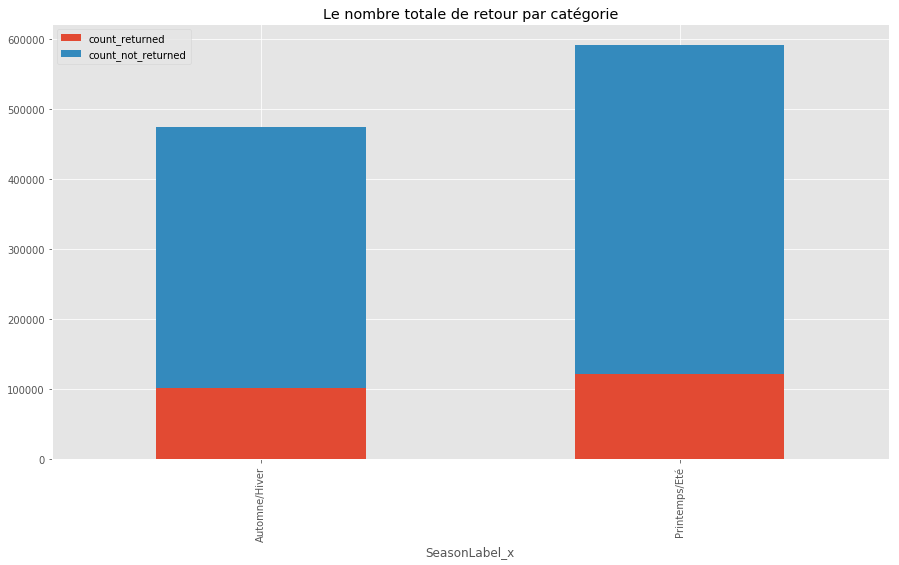

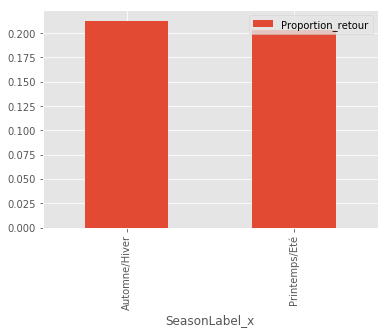

In [102]:
for i in col_cat_bin_remain:
    fonction_visualisation_en_bar(merge_all_train,i,(15,8))

visualisation des variables explicatives multiclasse:

In [87]:
col=col_remain
col_cat_mult_remain=[]
col_cat_mult_remain=np.array(col_cat_mult_remain)
for i in col:
    if (iscategorical_mult(merge_all_train[i])):
        col_cat_mult_remain=np.append(col_cat_mult_remain,i)

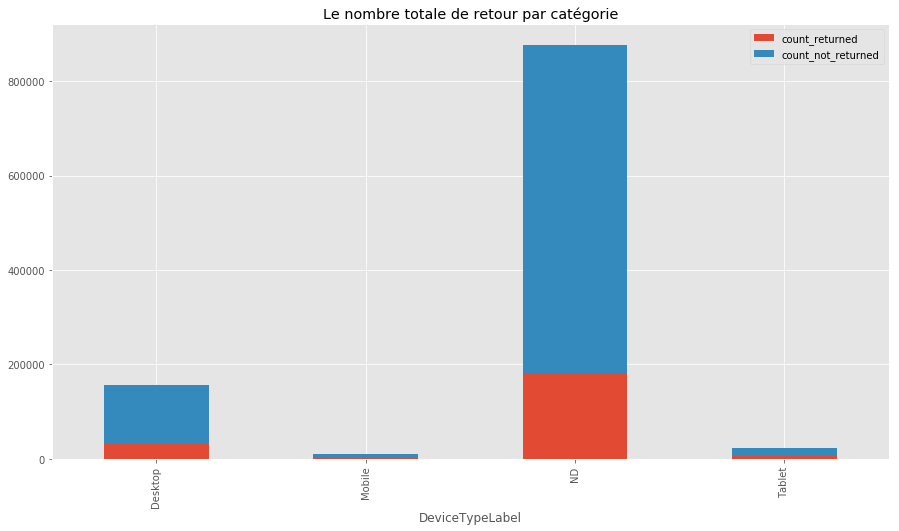

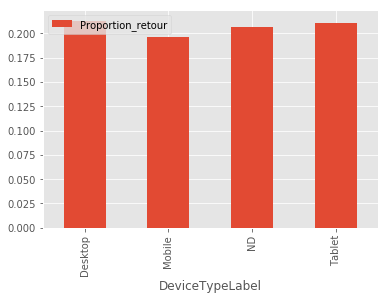

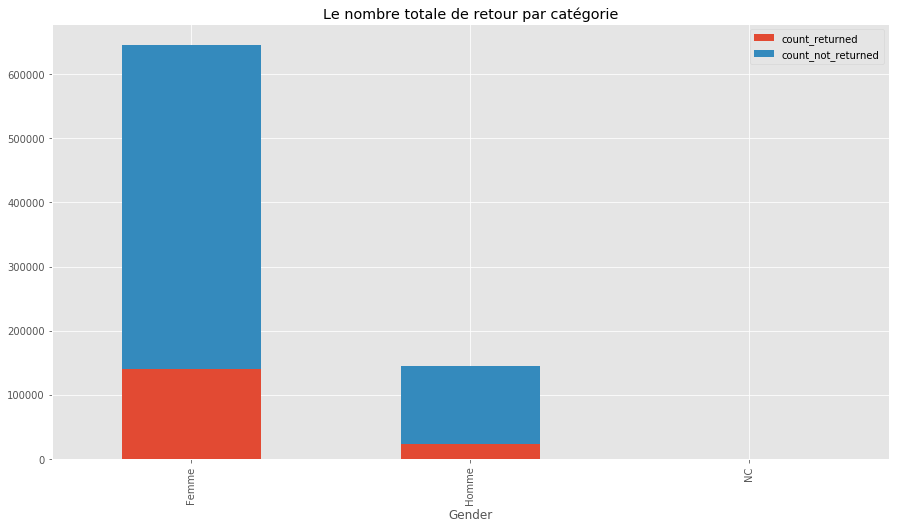

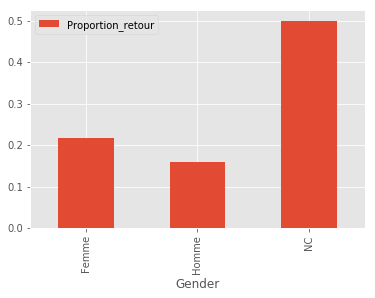

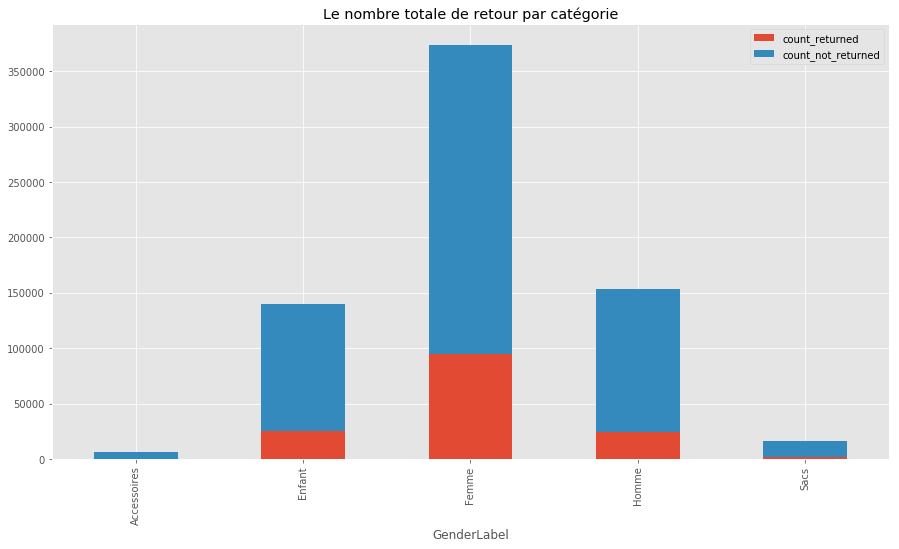

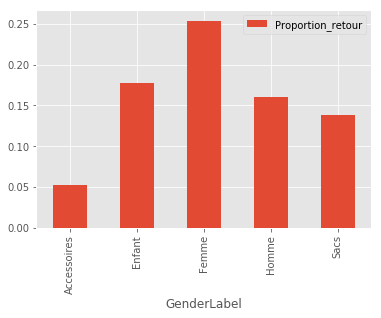

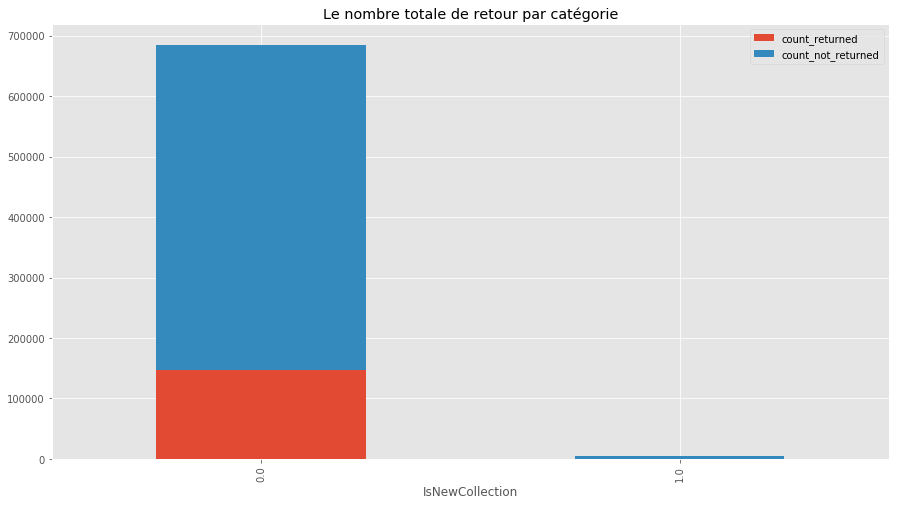

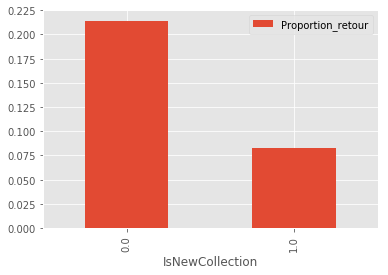

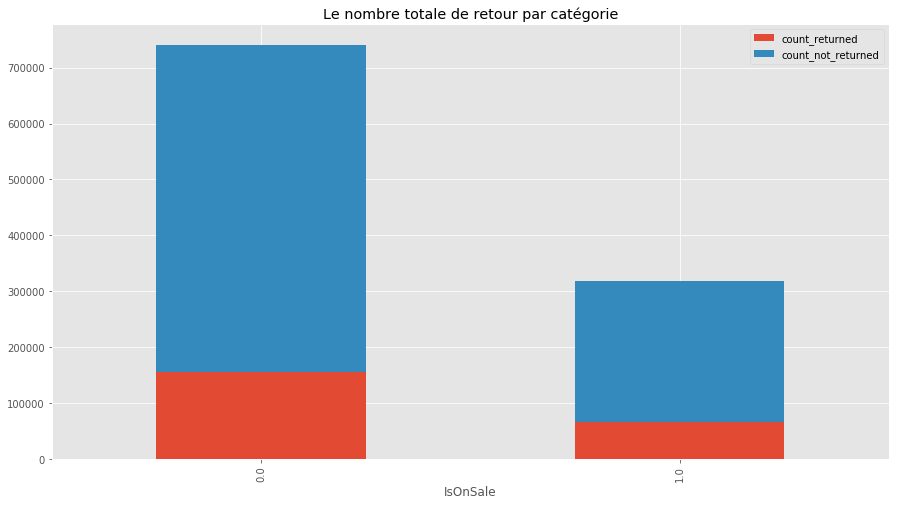

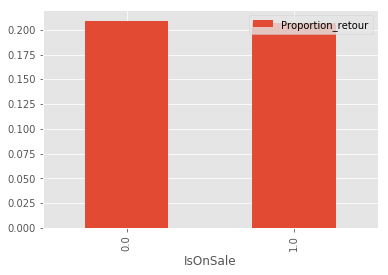

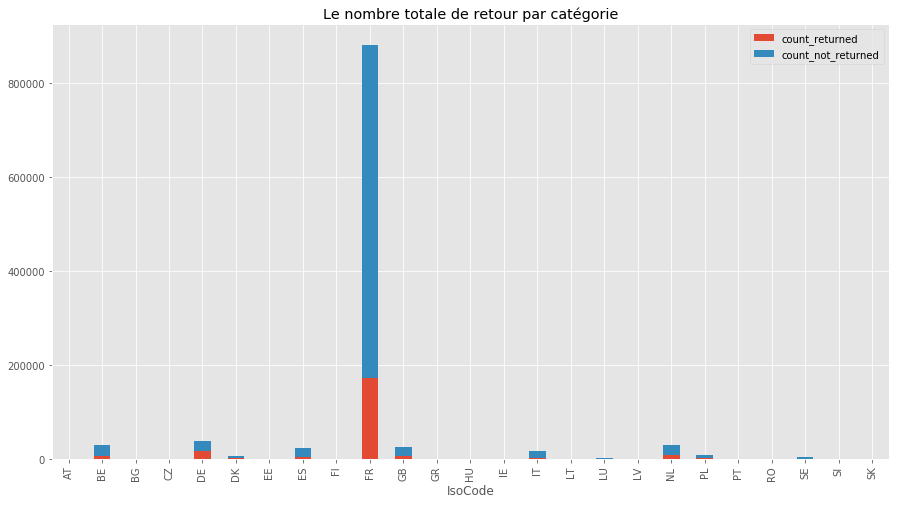

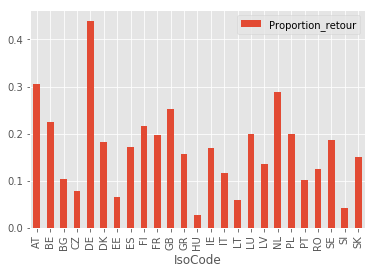

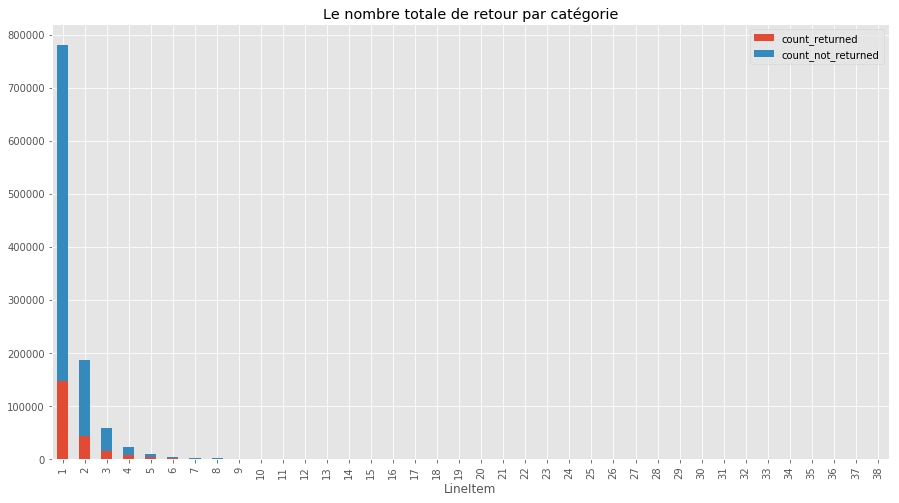

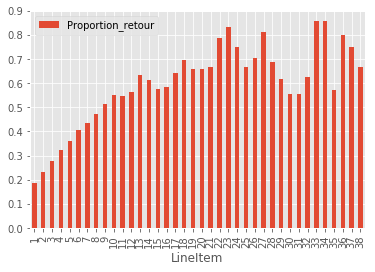

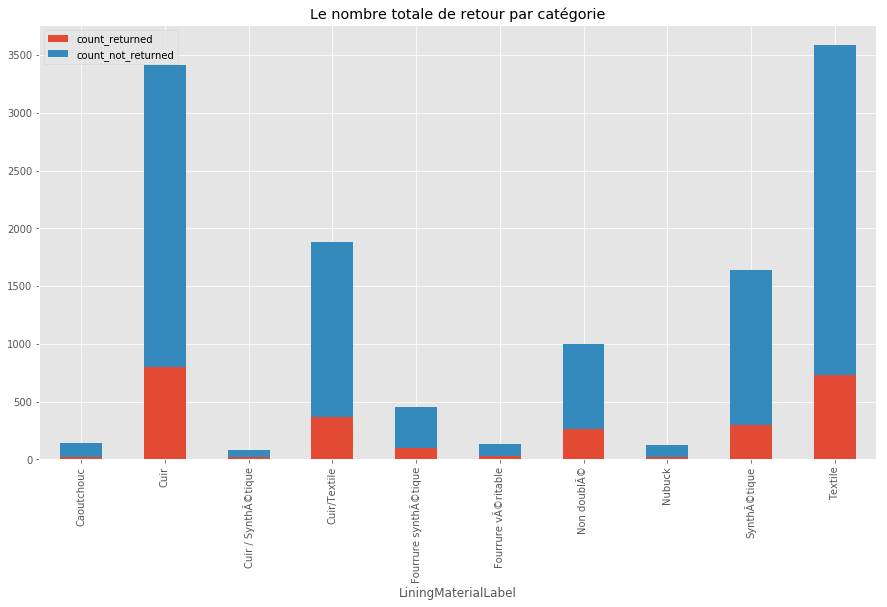

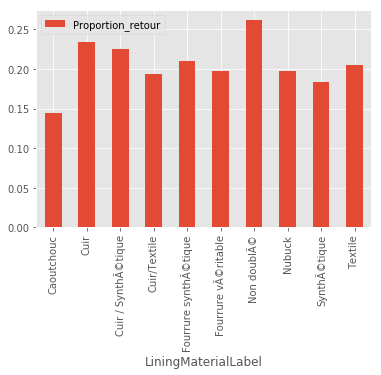

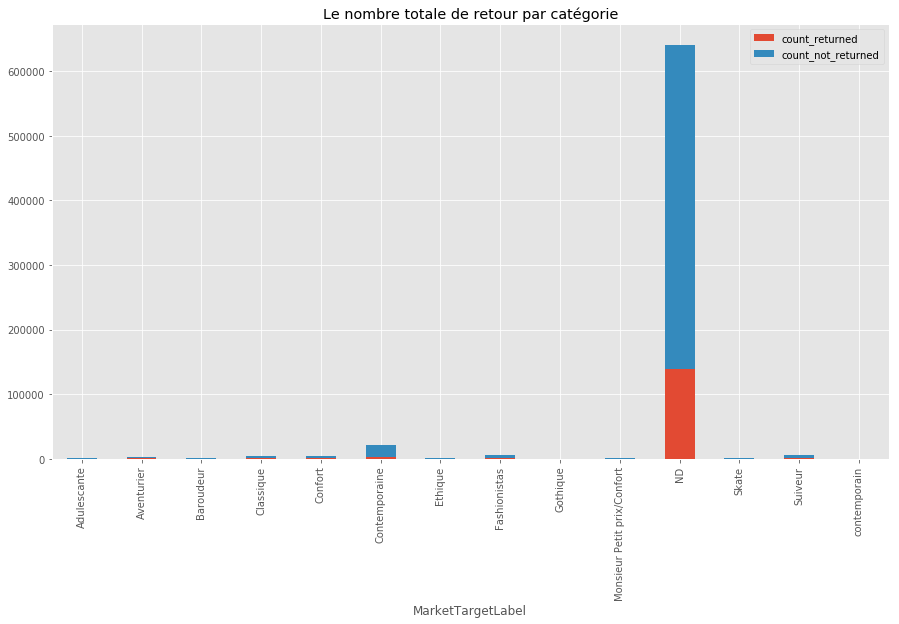

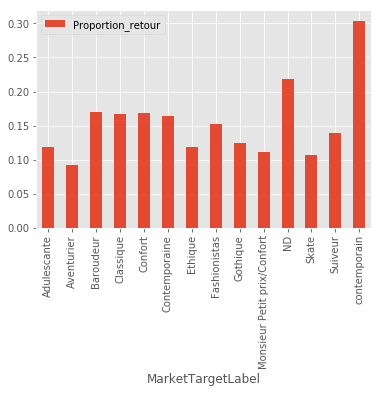

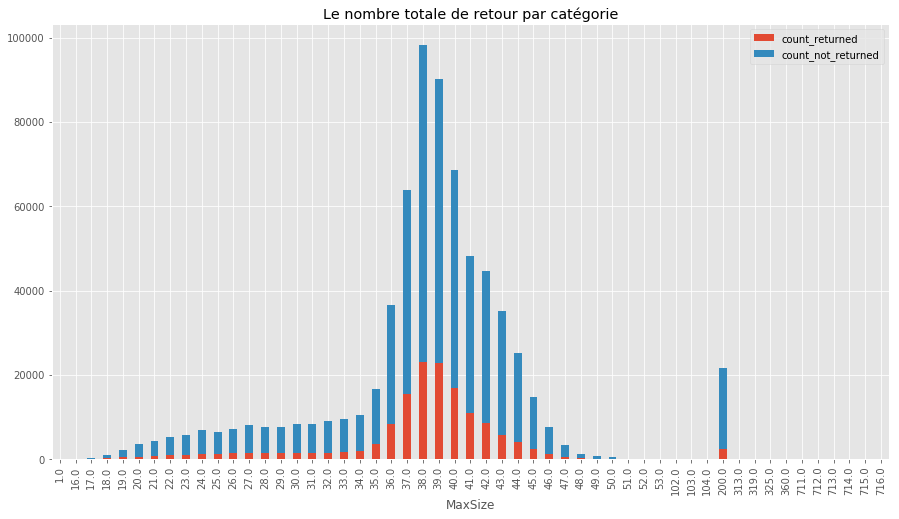

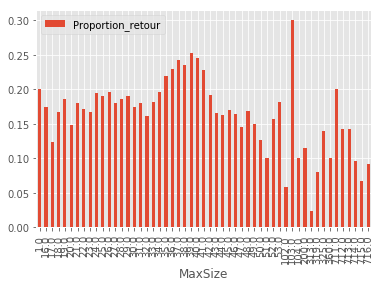

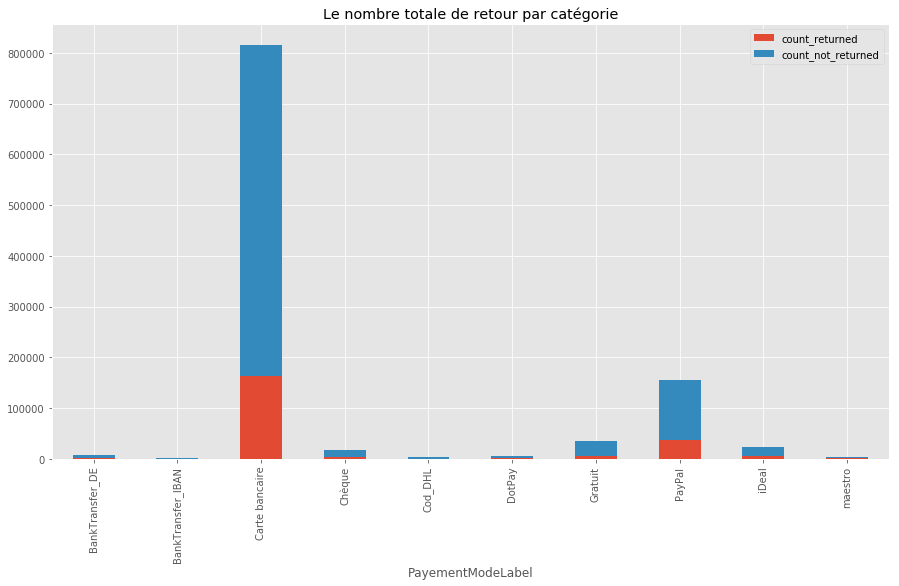

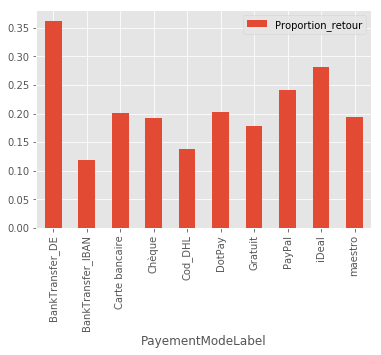

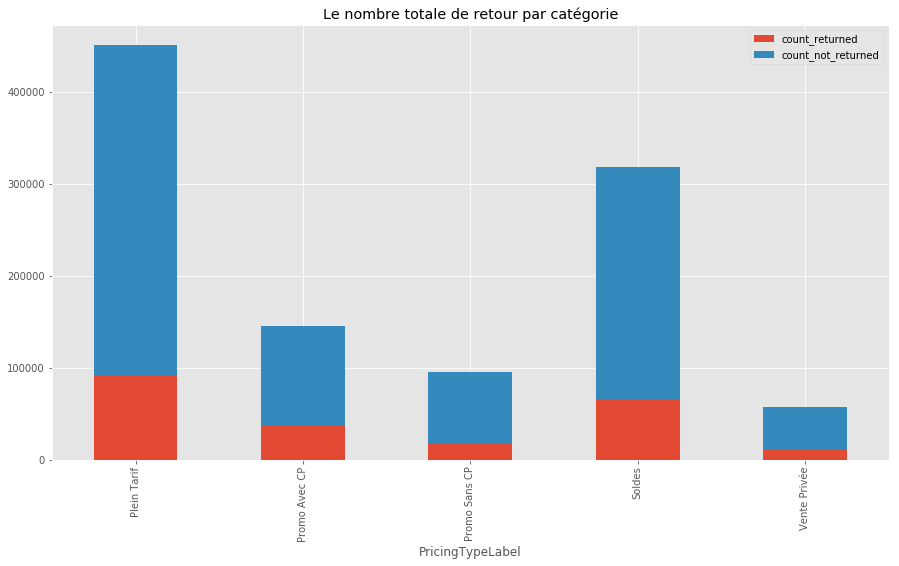

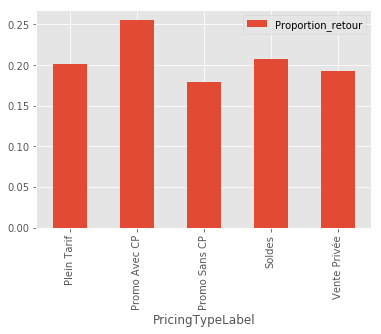

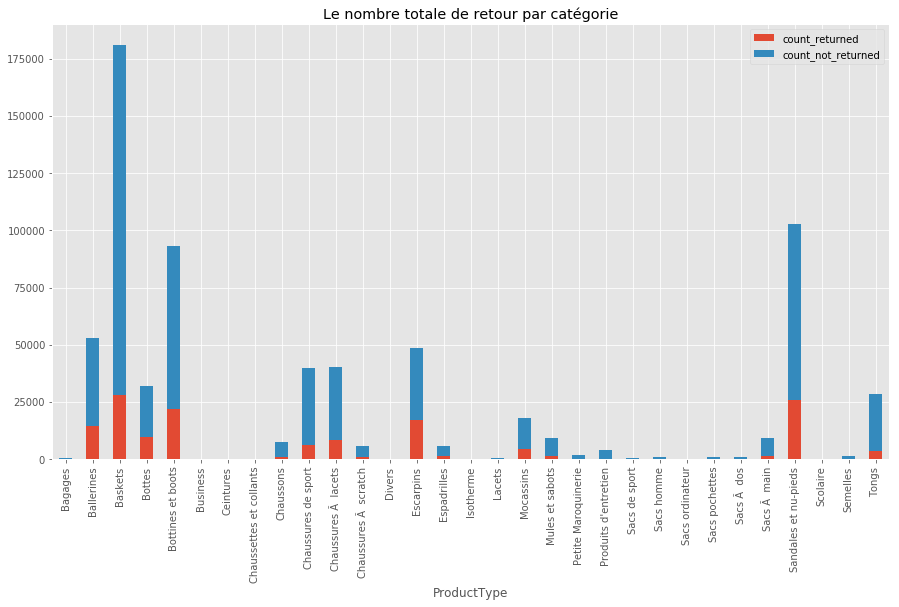

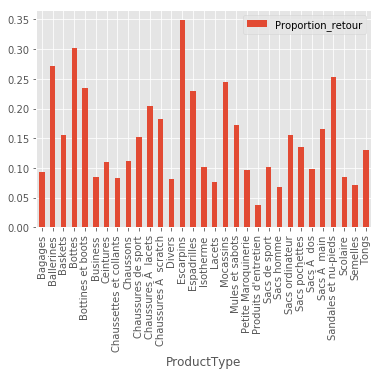

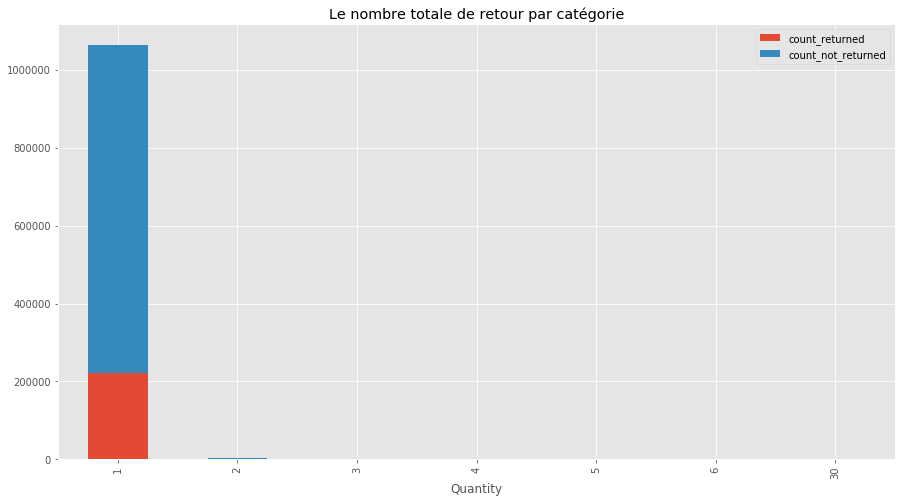

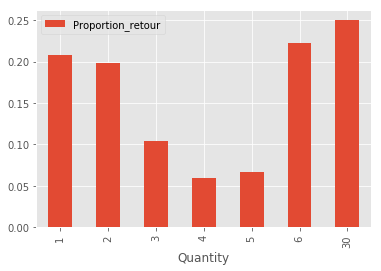

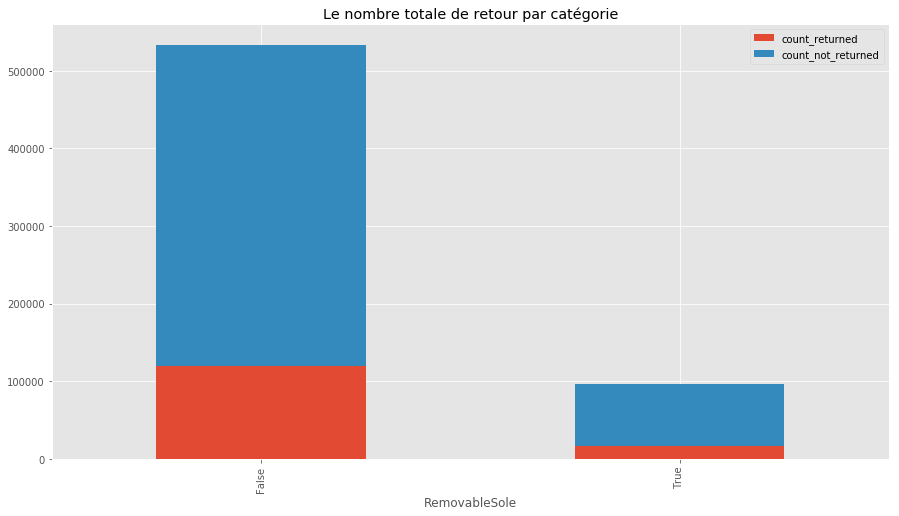

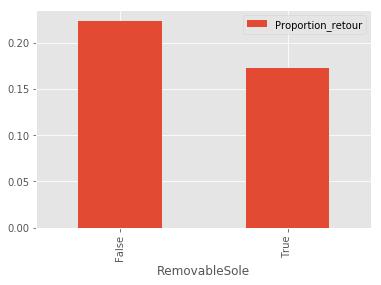

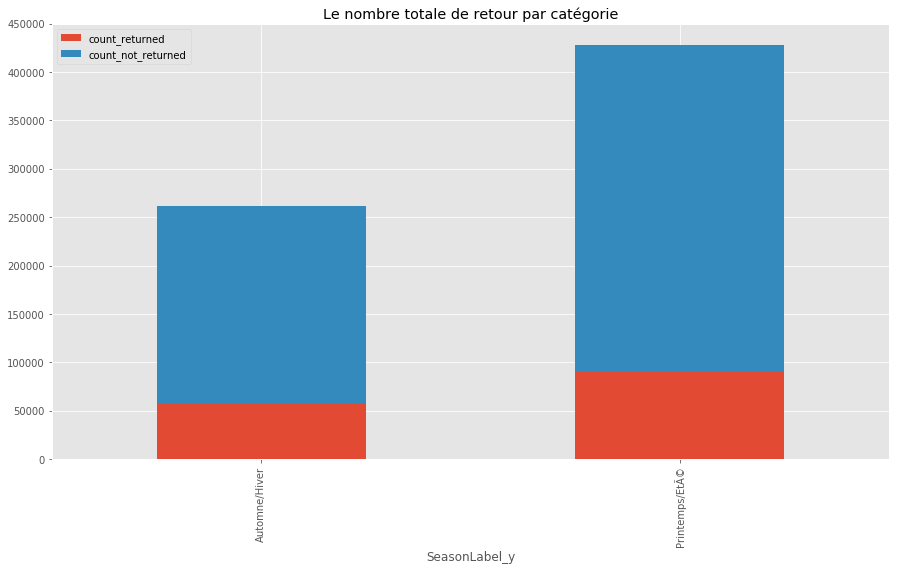

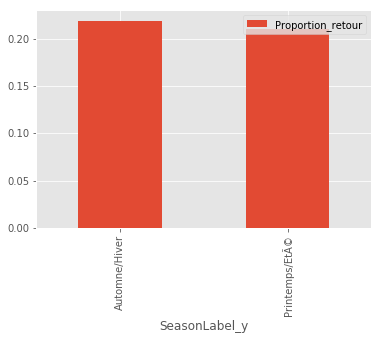

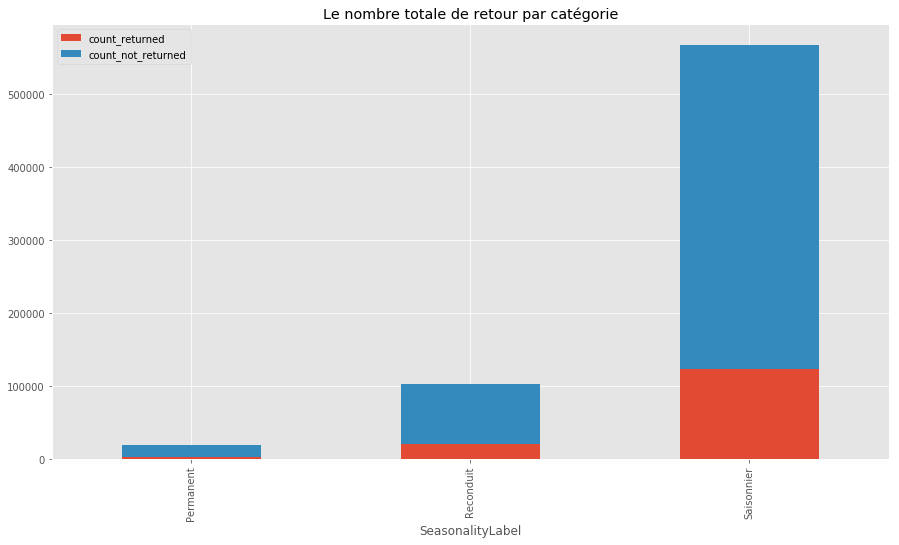

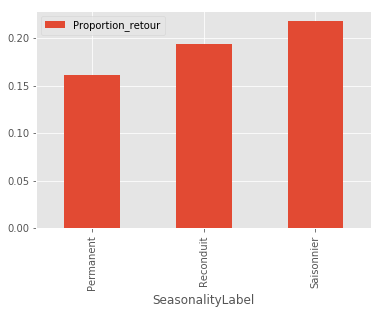

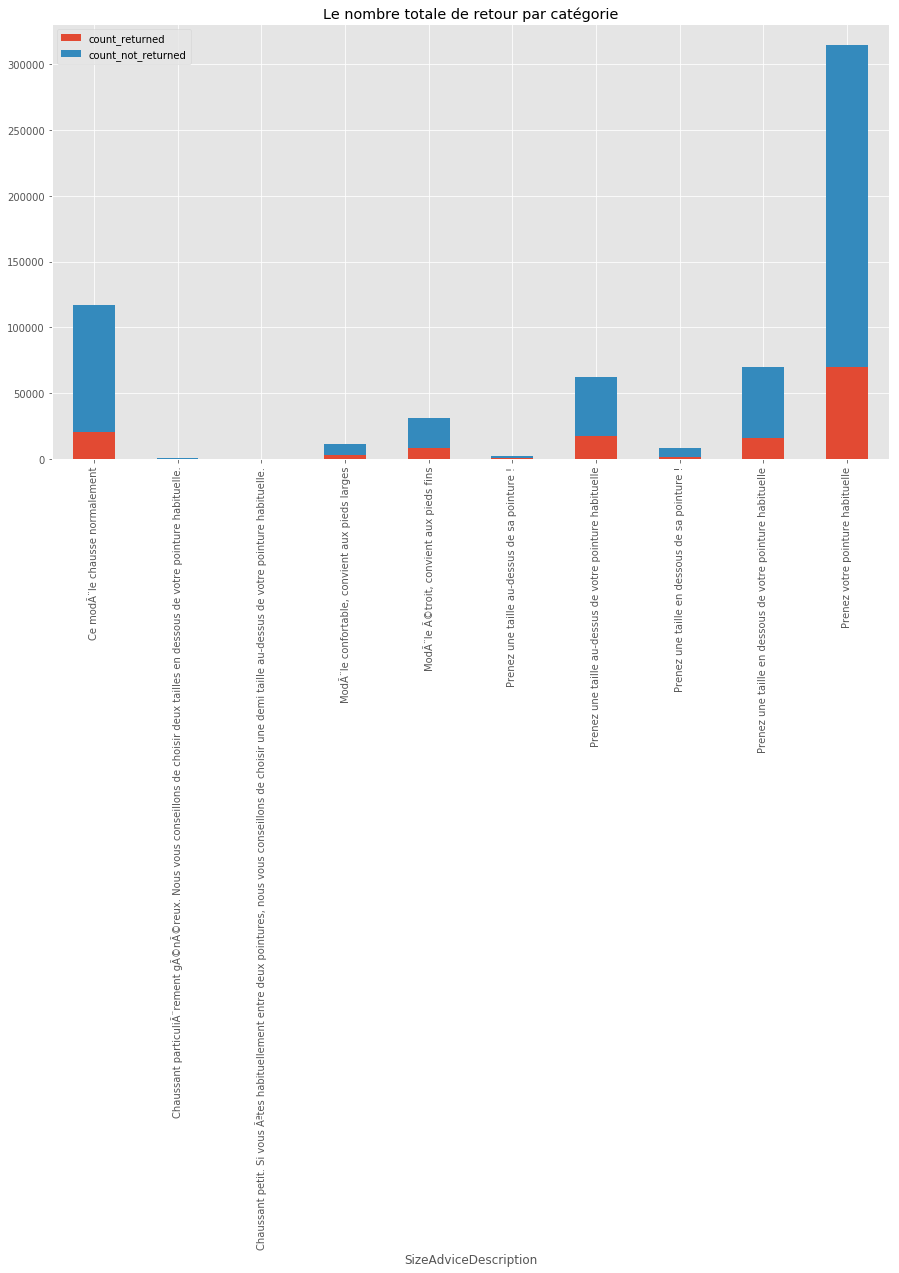

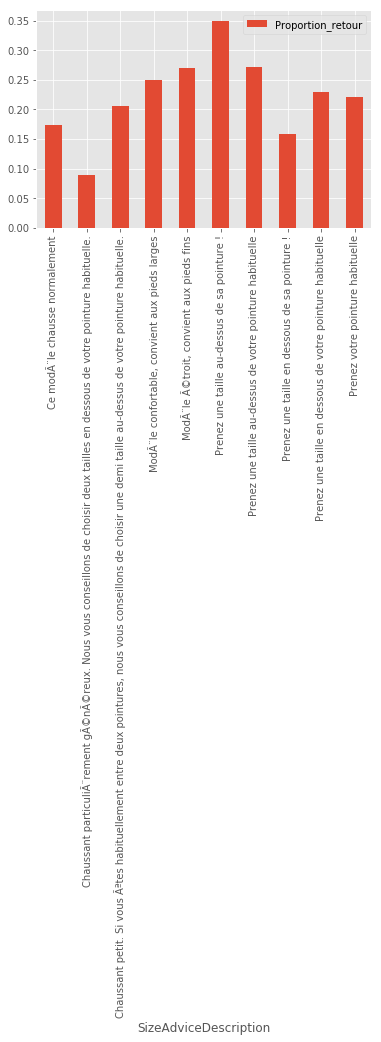

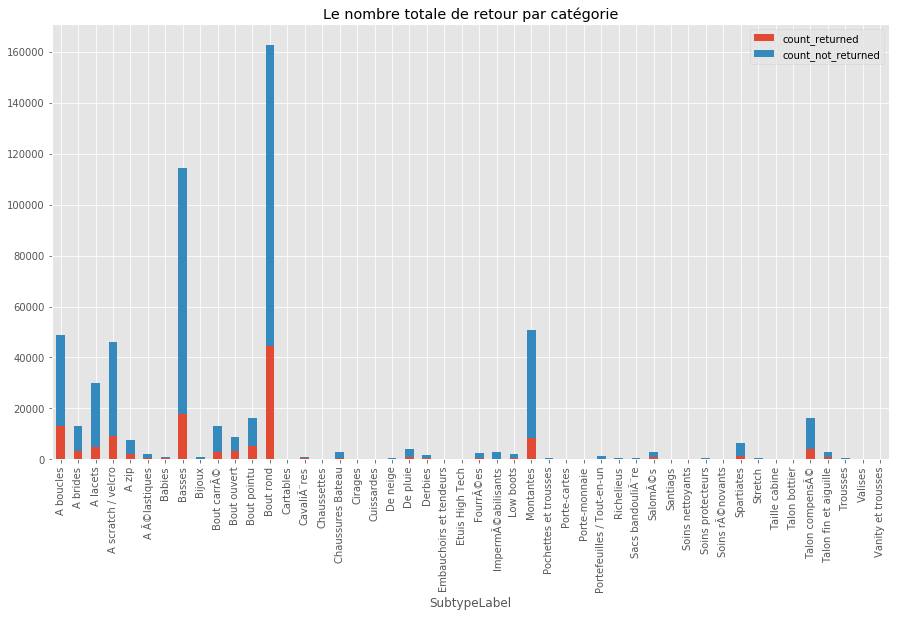

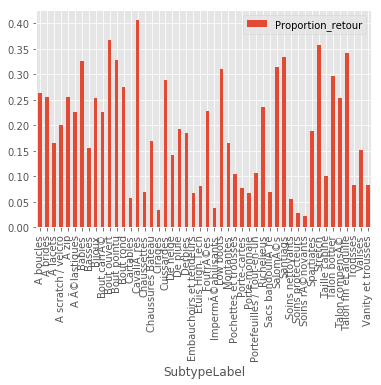

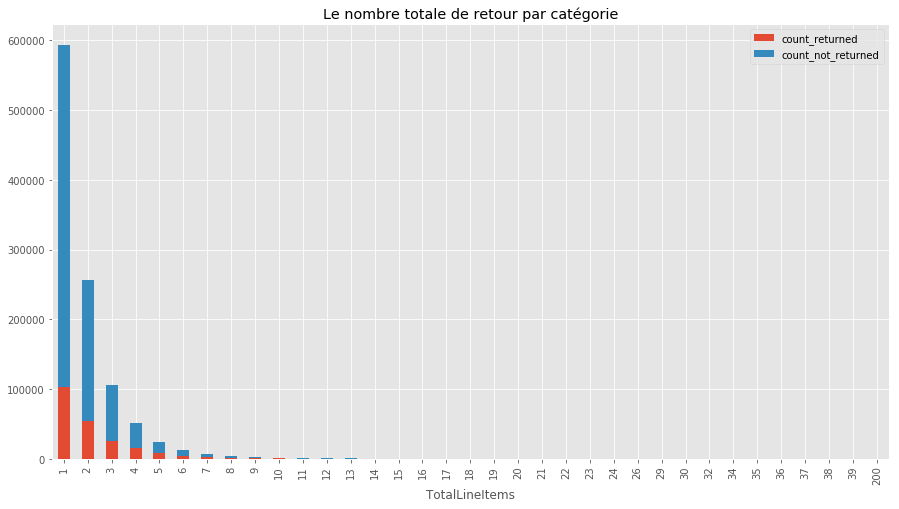

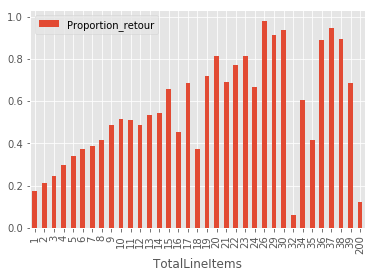

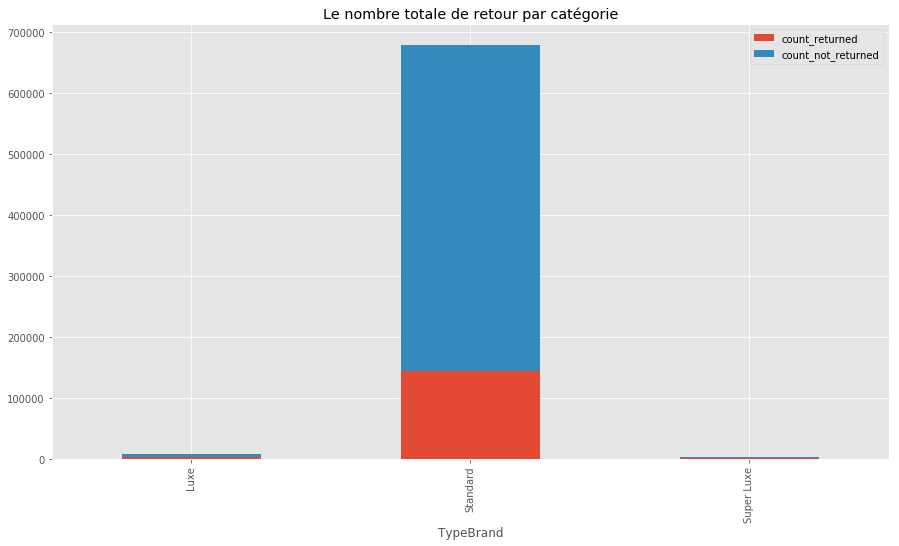

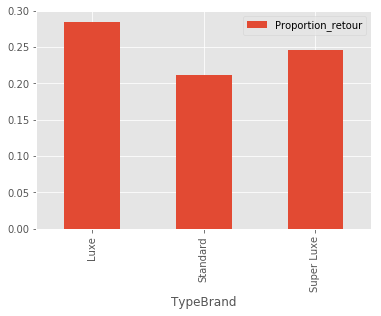

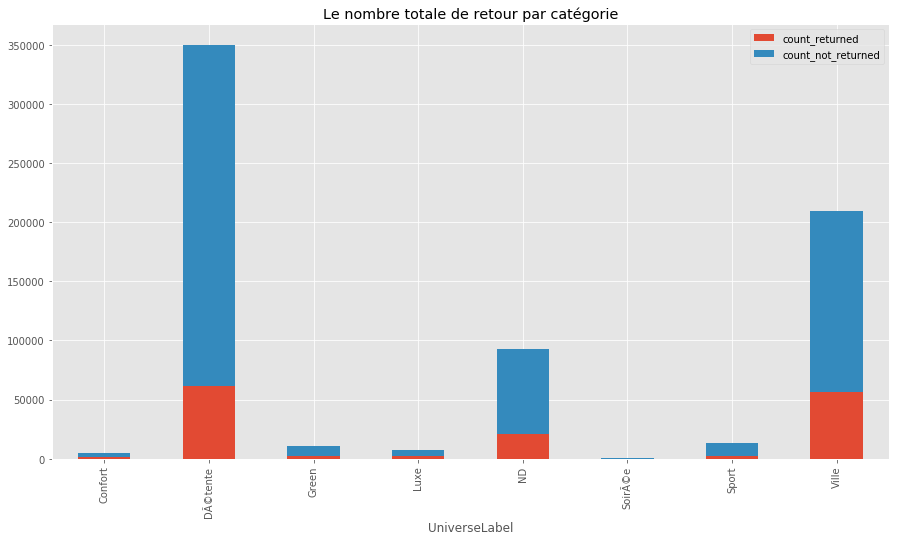

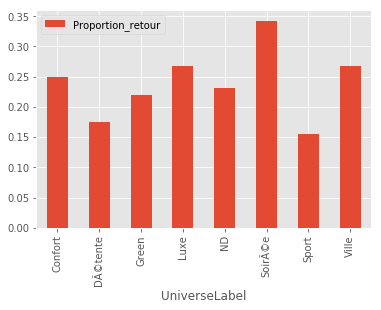

In [103]:
for i in col_cat_mult_remain:
    fonction_visualisation_en_bar(merge_all_train,i,(15,8))

Interprétation des variables les plus importantes :

In [14]:
def fonction_visualisation(merge_all_train,columnName):
    df=merge_all_train[y==1][columnName]
    df=df.reset_index()
    df1=merge_all_train[y==0][columnName]
    df1=df1.reset_index()
    a=df.groupby(columnName).count()
    b=df1.groupby(columnName).count()
    t=a.reset_index()
    t.rename(columns={'index':'count_returned'}, inplace=True)
    t1=b.reset_index()
    t1.rename(columns={'index':'count_not_returned'}, inplace=True)
    u=pd.merge(t,t1)
    u['Quantité total']=(u['count_not_returned']+u['count_returned'])
    u['Proportion_retour']=u['count_returned']/(u['count_not_returned']+u['count_returned'])
    u['retour/gardé']=u['count_returned']/(u['count_not_returned'])
    return u

In [105]:
fonction_visualisation(merge_all_train,'Gender').head()

,Gender,count_returned,count_not_returned,Quantité total,Proportion_retour,retour/gardé
0,Femme,140792,505258,646050,0.217927,0.278654
1,Homme,22815,121546,144361,0.158041,0.187707
2,NC,1,1,2,0.500000,1.000000


### Visualisation des variables numériques:

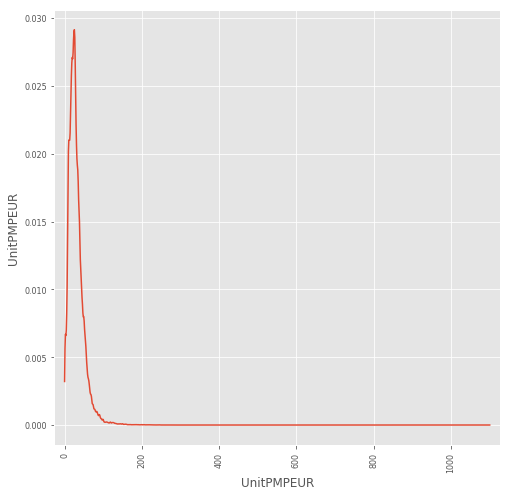

In [106]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(merge_all_train.get(['UnitPMPEUR']), alpha=0.2, figsize=(8, 8), diagonal='kde');

In [107]:
merge_all_train['UnitPMPEUR'].max()

1100.0

In [108]:
merge_all_train['UnitPMPEUR'].min()

0.0

In [109]:
merge_all_train['UnitPMPEUR'].mean()

29.83289107477443

### Visualisation des variables temporelles:

In [13]:
merge_all_train.BirthDate=pd.to_datetime(merge_all_train.BirthDate,errors = 'coerce')
merge_all_train.BirthDate=merge_all_train.BirthDate.dt.year


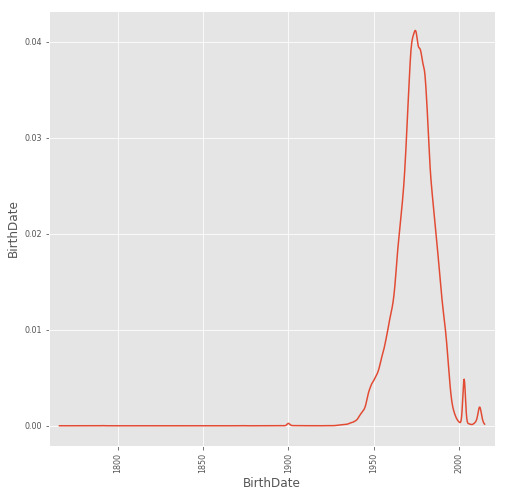

In [14]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(merge_all_train.get(['BirthDate']), alpha=0.2, figsize=(8, 8), diagonal='kde');

## Selection de model:

In [15]:
def funk_mask(d,j=5,index_purchase=5,isIsozip=False):
    
    MAPPING={}
    MAPPINGPurchasePrice={}
    
    for i in range(j):
        MAPPING[np.str(i)]=i
    
    for i in range(j,j+index_purchase):
        MAPPINGPurchasePrice[np.str(i)]=i


        
    " Defining a simple mask over the input data "
    columns_ext=['VariantId', 'CustomerId', 'UnitPMPEUR',
       'OrderCreationDate', 'OrderShipDate', 'IsOnSale',
       'BillingPostalCode',
       'SeasonalityLabel',
       'ProductId', 'SupplierColor', 'ProductColorId',
       'MinSize', 'UpperHeight', 'HeelHeight', 'SubtypeLabel',
       'UpperMaterialLabel', 'LiningMaterialLabel', 'OutSoleMaterialLabel',
       'RemovableSole', 'SizeAdviceDescription', 'CountryISOCode', 'BirthDate',
        'FirstOrderDate','PurchasePriceHT']
    
    X1 = d.loc[:,[xx for xx in d.columns if xx not in columns_ext]]
    
    ## La colonne UnitPMPEUR:###########################################################
    d.UnitPMPEUR =pd.to_numeric(d.UnitPMPEUR.str.replace(',','.'))
    d.UnitPMPEUR=pd.qcut(d.UnitPMPEUR,j, labels=[np.str(i) for i in range(j)])
    d.UnitPMPEUR= d.UnitPMPEUR.map(MAPPING)
    a=pd.get_dummies(d.UnitPMPEUR)
    ####################################################################################
        

    ## La colonne Purchase Products:###########################################################
    d.PurchasePriceHT=pd.qcut(d.PurchasePriceHT,index_purchase, labels=[np.str(i) for i in range(j,j+index_purchase)])
    d.PurchasePriceHT= d.PurchasePriceHT.map(MAPPINGPurchasePrice)
    PurchasePriceHTDummies=pd.get_dummies(d.PurchasePriceHT)
    ####################################################################################

                                   
    columns2bin = [x for x in X1.columns if X1[x].dtype == np.dtype('O')]
    X2 = pd.get_dummies(X1.loc[:,columns2bin])
    X1 = X1.loc[:,[xx for xx in X1.columns if xx not in columns2bin]]
#     X1 = X1.fillna(X1.median())
#     imp=Imputer(missing_values=np.nan ,strategy='most_frequent',axis=1)
#     X1=pd.DataFrame(imp.fit_transform(X1))
    X1 = X1.fillna(X1.median())
    X2 = X2.fillna(0)


    res = pd.concat([X1,X2,a,PurchasePriceHTDummies],axis=1)
    return(res)

In [16]:
merge_all_train=pd.merge(merge_train,products,how='left',on='VariantId')
merge_all_test=pd.merge(merge_test,products,how='left',on='VariantId')

In [17]:
merge_all_train.LineItem=merge_all_train.LineItem.astype('object')
merge_all_test.LineItem=merge_all_test.LineItem.astype('object')

## La colonne DateBirth de Customers:###########################################################
merge_all_train.BirthDate=pd.to_datetime(merge_all_train.BirthDate,errors = 'coerce')
merge_all_train['Birth_Years']=2018-merge_all_train.BirthDate.dt.year
merge_all_train['Birth_Month']=merge_all_train.BirthDate.dt.month
merge_all_train['Birth_Day']=merge_all_train.BirthDate.dt.day
merge_all_train=merge_all_train.drop(['BirthDate'],axis=1)

####################################################################################

merge_all_test.BirthDate=pd.to_datetime(merge_all_test.BirthDate,errors = 'coerce')
merge_all_test['Birth_Years']=2018-merge_all_test.BirthDate.dt.year
merge_all_test['Birth_Month']=merge_all_test.BirthDate.dt.month
merge_all_test['Birth_Day']=merge_all_test.BirthDate.dt.day
merge_all_test=merge_all_test.drop(['BirthDate'],axis=1)

## La colonne OrderCreationDate de Order:###########################################################
merge_all_train.OrderCreationDate=pd.to_datetime(merge_all_train.OrderCreationDate,errors = 'coerce')
merge_all_train['OrderCreationDate_Years']=merge_all_train.OrderCreationDate.dt.year
merge_all_train['OrderCreationDate_Month']=merge_all_train.OrderCreationDate.dt.month
merge_all_train['OrderCreationDate_Day']=merge_all_train.OrderCreationDate.dt.day
merge_all_train['OrderCreationDate_Hour']=merge_all_train.OrderCreationDate.dt.hour
merge_all_train['OrderCreationDate_min']=merge_all_train.OrderCreationDate.dt.minute
merge_all_train['OrderCreationDate_sec']=merge_all_train.OrderCreationDate.dt.second
merge_all_train=merge_all_train.drop(['OrderCreationDate'],axis=1)

####################################################################################

## La colonne OrderCreationDate de Order:###########################################################
merge_all_test.OrderCreationDate=pd.to_datetime(merge_all_test.OrderCreationDate,errors = 'coerce')
merge_all_test['OrderCreationDate_Years']=merge_all_test.OrderCreationDate.dt.year
merge_all_test['OrderCreationDate_Month']=merge_all_test.OrderCreationDate.dt.month
merge_all_test['OrderCreationDate_Day']=merge_all_test.OrderCreationDate.dt.day
merge_all_test['OrderCreationDate_Hour']=merge_all_test.OrderCreationDate.dt.hour
merge_all_test['OrderCreationDate_min']=merge_all_test.OrderCreationDate.dt.minute
merge_all_test['OrderCreationDate_sec']=merge_all_test.OrderCreationDate.dt.second
merge_all_test=merge_all_test.drop(['OrderCreationDate'],axis=1)

####################################################################################

## La colonne OrderCreationDate de Order:###########################################################
merge_all_train.OrderShipDate=pd.to_datetime(merge_all_train.OrderShipDate,errors = 'coerce')
merge_all_train['OrderShipDate_Years']=merge_all_train.OrderShipDate.dt.year
merge_all_train['OrderShipDate_Month']=merge_all_train.OrderShipDate.dt.month
merge_all_train['OrderShipDate_Day']=merge_all_train.OrderShipDate.dt.day
merge_all_train['OrderShipDate_Hour']=merge_all_train.OrderShipDate.dt.hour
merge_all_train['OrderShipDate_min']=merge_all_train.OrderShipDate.dt.minute
merge_all_train['OrderShipDate_sec']=merge_all_train.OrderShipDate.dt.second
merge_all_train=merge_all_train.drop(['OrderShipDate'],axis=1)

####################################################################################

## La colonne OrderCreationDate de Order:###########################################################
merge_all_test.OrderShipDate=pd.to_datetime(merge_all_test.OrderShipDate,errors = 'coerce')
merge_all_test['OrderShipDate_Years']=merge_all_test.OrderShipDate.dt.year
merge_all_test['OrderShipDate_Month']=merge_all_test.OrderShipDate.dt.month
merge_all_test['OrderShipDate_Day']=merge_all_test.OrderShipDate.dt.day
merge_all_test['OrderShipDate_Hour']=merge_all_test.OrderShipDate.dt.hour
merge_all_test['OrderShipDate_min']=merge_all_test.OrderShipDate.dt.minute
merge_all_test['OrderShipDate_sec']=merge_all_test.OrderShipDate.dt.second
merge_all_test=merge_all_test.drop(['OrderShipDate'],axis=1)

####################################################################################

In [18]:
from sklearn.model_selection import train_test_split
train_model, test_model, train_y, test_y = train_test_split(merge_all_train[:100000], y_train[:100000], test_size=0.2, random_state=42)

In [19]:
j=17
index_purchase=15
k=j+index_purchase

## pour l'instant la meilleur c'est j=15 score 64,323 roc
x1 = funk_mask(train_model,j,index_purchase)
x2 = funk_mask(test_model,j,index_purchase)

col={}
for i in range(k):
    col[i]=np.str(i)
x1.rename(index=str, columns=col,inplace=True)
x2.rename(index=str, columns=col,inplace=True)
seleckt_columns = np.intersect1d(x1.columns,x2.columns)
x1 = x1.loc[:,seleckt_columns]
x2 = x2.loc[:,seleckt_columns]

In [20]:
def score(merge_all_train,merge_all_test,train_y,test_y,clf):

    # fit the model 
    clf.fit(merge_all_train, train_y.ReturnQuantityBin)
    y_pred = clf.predict_proba(merge_all_test.loc[:,merge_all_train.columns])
    # score 
    return roc_auc_score(test_y.ReturnQuantityBin.iloc[:],y_pred[:,1])



#### LogisticRegression

In [21]:
import time
# Debut du decompte du temps
model=LogisticRegression()
start_time = time.time()
score1=score(x1,x2,train_y,test_y,model)
print('le score est : ',score1)
print("Temps d execution : %s secondes" % (time.time() - start_time))

le score est :  0.500746014262
Temps d execution : 0.9679994583129883 secondes


#### Decision Tree:

In [33]:
from sklearn.tree import DecisionTreeClassifier
import time
# Debut du decompte du temps
score_max=0
index=0
for i in range(5,30,3):    
    model=DecisionTreeClassifier(max_depth=i)
    start_time = time.time()
    score1=score(x1,x2,train_y,test_y,model)
    if (score1>score_max):
        score_max=score1
        index=i
print('le score est : ',score_max,' avec le max_depth egale à ',i)
print("Temps d execution : %s secondes" % (time.time() - start_time))

le score est :  0.619490970452  avec le max_depth egale à  29
Temps d execution : 2.8774871826171875 secondes


#### RandomForest :

In [37]:
from sklearn.ensemble import RandomForestClassifier
# Debut du decompte du temps
score_max=0
index=0
for i in range(5,30,3): 
    model=RandomForestClassifier(max_depth=i)
    start_time = time.time()
    score1=score(x1,x2,train_y,test_y,model)
    if (score1>score_max):
        score_max=score1
        index=i
print('le score est : ',score_max,' avec le max_depth egale à ',i)
print("Temps d execution : %s secondes" % (time.time() - start_time))

le score est :  0.642485536204  avec le max_depth egale à  29
Temps d execution : 2.288196563720703 secondes


#### Reseau de neurone:

In [38]:
from sklearn.neural_network import MLPClassifier 

NameError: name 'hidden_layer_sizes' is not defined

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Debut du decompte du temps
score_max=0
index=0
index_j=0
index_k=0
for i in range(5,1000,50):
    max_iter = i
    for j in range(5,30,3):
        for k in range (50,90,10):

            hidden_layer_sizes = (j,k)
            learning_rate_init = 0.001
            model=MLPClassifier(solver=solver, learning_rate='adaptive',
                    hidden_layer_sizes=hidden_layer_sizes,
                    learning_rate_init=learning_rate_init,
                    max_iter=max_iter, activation='logistic',
                    verbose=0, random_state=0)
            start_time = time.time()
            score1=score(x1,x2,train_y,test_y,model)
            if (score1>score_max):
                score_max=score1
                index=i
                index_k=k
                index_j=j
print('le score est : ',score_max,' avec le max_depth egale à ',i,j,k)
print("Temps d execution : %s secondes" % (time.time() - start_time))